In [1]:
# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from IPython.display import display

# remove warnings
import warnings
warnings.filterwarnings('ignore')

# Load and pick Datas

In [2]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

print train_data.shape
display(train_data.head(1))
# display(train_data.info())

print test_data.shape
display(test_data.head(1))
# display(test_data.info())

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500


(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal


In [3]:
previous_num_columns = train_data.select_dtypes(exclude=['object']).columns.values.tolist()
previous_num_columns.remove('Id')
previous_num_columns.remove('SalePrice')
print previous_num_columns

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


train: (1,)
test: (0,)


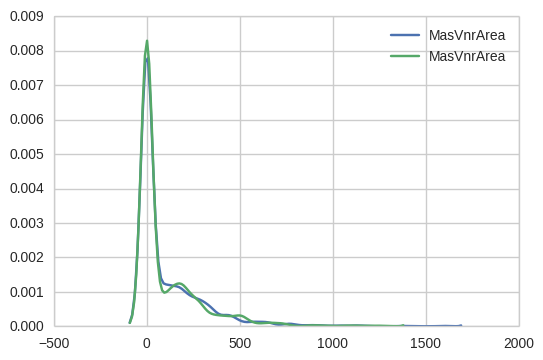

In [4]:
test_column = 'MasVnrArea'
sns.kdeplot(train_data[test_column])
sns.kdeplot(test_data[test_column])

print 'train:', train_data[test_column][train_data[test_column] > 1500].shape
print 'test:', test_data[test_column][test_data[test_column] > 1500].shape

Delete some outlier datas

In [5]:
print train_data.shape
train_data.drop(train_data[train_data["LotFrontage"] > 200].index, inplace=True)
train_data.drop(train_data[train_data["LotArea"] > 70000].index, inplace=True)
train_data.drop(train_data[train_data["MasVnrArea"] > 1500].index, inplace=True)
print train_data.shape

train_length = train_data.shape[0]

(1460, 81)
(1452, 81)


Conbine train and test data

In [6]:
conbined_data = pd.concat([train_data.loc[:, : 'SalePrice'], test_data])
conbined_data = conbined_data[test_data.columns]
display(conbined_data.head(1))
print conbined_data.shape

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal


(2911, 80)


# Filling up missing values

In [7]:
# miss data columns
has_null_columns = conbined_data.columns[conbined_data.isnull().any()].tolist()
# how many data missed each column of train/test/conbine datas
train_null = train_data[has_null_columns].isnull().sum()
test_null = test_data[has_null_columns].isnull().sum()
conbined_null = conbined_data[has_null_columns].isnull().sum()

print 'how many data missed each column of train/test/conbine datas'
missed_data = pd.DataFrame(data=[train_null, test_null, conbined_null],
                             index=['train', 'test', 'conbine'], 
                             columns=has_null_columns)
missed_data

how many data missed each column of train/test/conbine datas


,MSZoning,LotFrontage,Alley,Utilities,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,BsmtQual,BsmtCond,...,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PoolQC,Fence,MiscFeature,SaleType
train,0,256,1362,0,0,0,8,8,37,37,...,81,81,0,0,81,81,1446,1171,1400,0
test,4,227,1352,2,1,1,16,15,44,45,...,78,78,1,1,78,78,1456,1169,1408,1
conbine,4,483,2714,2,1,1,24,23,81,82,...,159,159,1,1,159,159,2902,2340,2808,1


In [8]:
def fill_missing_conbined_data(column, value):
    conbined_data.loc[conbined_data[column].isnull(),column] = value

** LotFrontage/LotArea **

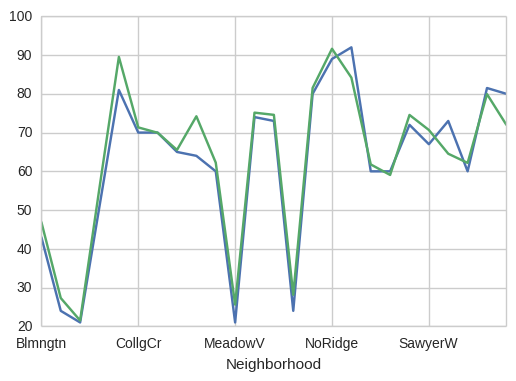

In [9]:
conbined_data['LotFrontage'].groupby(conbined_data["Neighborhood"]).median().plot()
conbined_data['LotFrontage'].groupby(conbined_data["Neighborhood"]).mean().plot()

In [10]:
lf_neighbor_map = conbined_data['LotFrontage'].groupby(conbined_data["Neighborhood"]).median()
    
rows = conbined_data['LotFrontage'].isnull()
conbined_data['LotFrontage'][rows] = conbined_data['Neighborhood'][rows].map(lambda neighbor : lf_neighbor_map[neighbor])

In [11]:
conbined_data[conbined_data['LotFrontage'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition


** Alley **

In [12]:
conbined_data.shape, conbined_data[conbined_data['Alley'].isnull()].shape

((2911, 80), (2714, 80))

In [13]:
fill_missing_conbined_data('Alley', 'NA')

** MasVnrType / MasVnrArea **

In [14]:
conbined_data['MasVnrType'].fillna('None', inplace=True)
conbined_data['MasVnrArea'].fillna(0, inplace=True)

** BsmtQual / BsmtCond / BsmtExposure / BsmtFinType1 / BsmtFinType2 **

In [15]:
basement_cols=['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtFinSF1','BsmtFinSF2']

In [16]:
# NA:No Basement
for column in basement_cols:
    if 'FinSF'not in column:
        # NA	No Basement
        fill_missing_conbined_data(column, 'NA')

In [17]:
fill_missing_conbined_data('BsmtFinSF1', 0)
fill_missing_conbined_data('BsmtFinSF2', 0)

** Electrical **

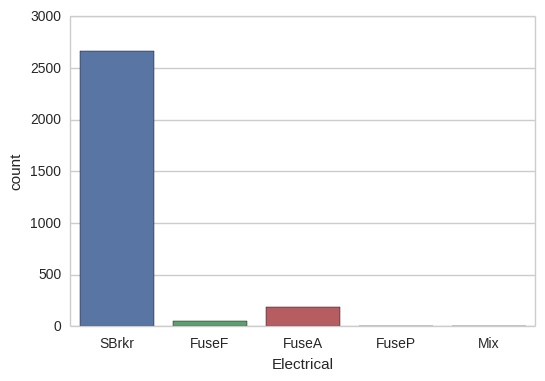

In [18]:
sns.countplot(conbined_data['Electrical'])

In [19]:
fill_missing_conbined_data('Electrical', 'SBrkr')

** FireplaceQu **

In [20]:
# 对于 Fireplaces 为 0 的，FireplaceQu 设置为 NA，表示 No Fireplace，此即缺失的 1420 条数据的情况
fill_missing_conbined_data('FireplaceQu', 'NA')

** PoolQC **

In [21]:
fill_missing_conbined_data('PoolQC', 'NA')

** MiscFeature **

In [22]:
fill_missing_conbined_data('MiscFeature', 'NA')

** Fence **

In [23]:
fill_missing_conbined_data('Fence', 'NA')

** Garages **

In [24]:
garage_cols=['GarageType','GarageQual','GarageCond','GarageYrBlt','GarageFinish','GarageCars','GarageArea']
conbined_data[garage_cols][conbined_data['GarageType'].isnull()==True].head(1)

,GarageType,GarageQual,GarageCond,GarageYrBlt,GarageFinish,GarageCars,GarageArea
39,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [25]:
# NA : No Garage
for column in garage_cols:
    if column != 'GarageCars' and column != 'GarageArea':
        # NA	No Basement
        fill_missing_conbined_data(column, 'NA')
    else:
        fill_missing_conbined_data(column, 0)

** MSZoning **

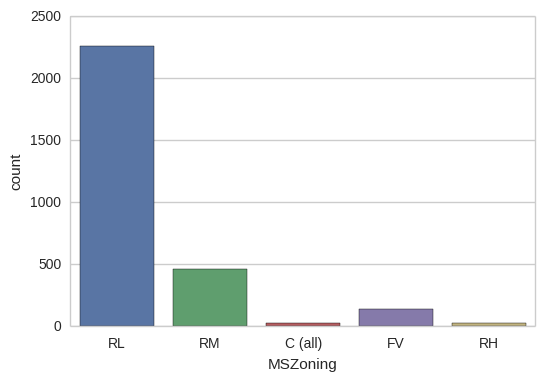

In [26]:
sns.countplot(conbined_data['MSZoning'])

In [27]:
fill_missing_conbined_data('MSZoning', 'RL')

** Utilities **

**Definitely ignoring Utilities** : all records are "AllPub", except for one "NoSeWa" in the train set and 2 NA in the test set.

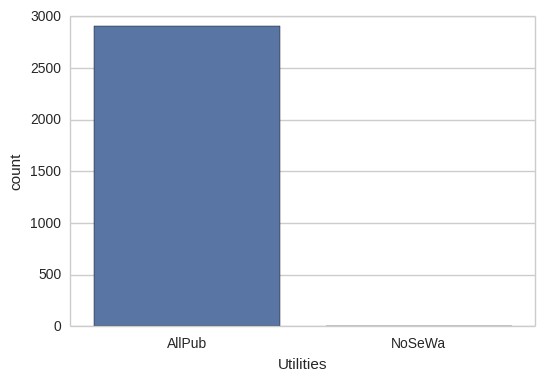

In [28]:
sns.countplot(conbined_data['Utilities'])

In [29]:
fill_missing_conbined_data('Utilities', 'AllPub')

** Exterior1st / Exterior2nd**

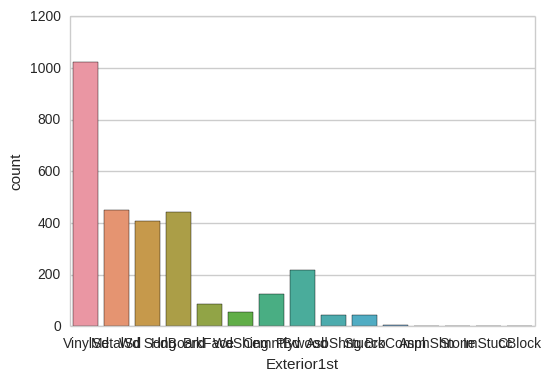

In [30]:
sns.countplot(conbined_data['Exterior1st'])

In [31]:
fill_missing_conbined_data('Exterior1st', 'VinylSd')

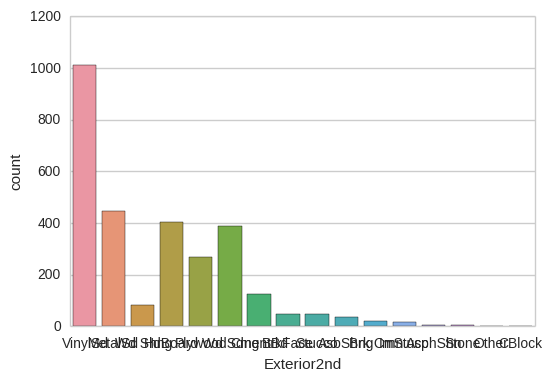

In [32]:
sns.countplot(conbined_data['Exterior2nd'])

In [33]:
fill_missing_conbined_data('Exterior2nd', 'VinylSd')

** BsmtUnfSF / TotalBsmtSF **

In [34]:
# 可以发现，对于缺失的 TotalBsmtSF 和 BsmtUnfSF 填充为0
fill_missing_conbined_data('BsmtUnfSF', 0)
fill_missing_conbined_data('TotalBsmtSF', 0)

** BsmtFullBath / BsmtHalfBath **

In [35]:
fill_missing_conbined_data('BsmtFullBath', 0)
fill_missing_conbined_data('BsmtHalfBath', 0)

** KitchenQual **

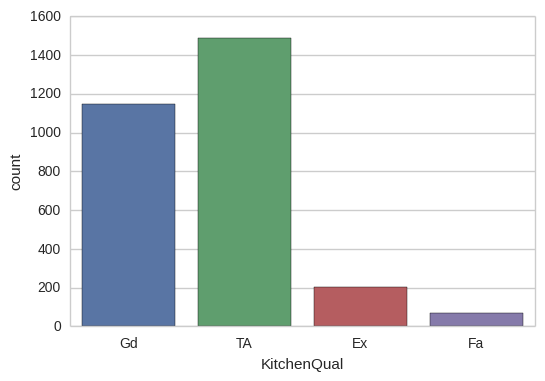

In [36]:
sns.countplot(conbined_data['KitchenQual'])

In [37]:
fill_missing_conbined_data('KitchenQual', 'TA')

** SaleType / Functional **

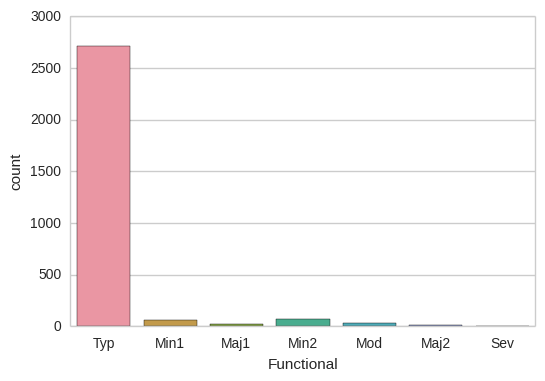

In [38]:
sns.countplot(conbined_data['Functional'])

In [39]:
fill_missing_conbined_data('SaleType', 'WD')
fill_missing_conbined_data('Functional', 'Typ')

In [40]:
has_null_columns = conbined_data.columns[conbined_data.isnull().any()].tolist()
conbined_data[has_null_columns].isnull().sum()

Series([], dtype: float64)

# Feature Engineering

** Time properties（YearBuilt、GarageYrBlt）**

In [41]:
built_year_data = conbined_data[['YearBuilt', 'GarageYrBlt']][conbined_data['GarageYrBlt'] != 'NA']

In [42]:
built_year_data['GarageYrBlt'] = built_year_data['GarageYrBlt'].map(lambda g : int(g))
built_year_data['GarageYrBlt'].corr(built_year_data['YearBuilt'])

0.8346885266143993

In [43]:
built_year_data.head(1)

,YearBuilt,GarageYrBlt
0,2003,2003


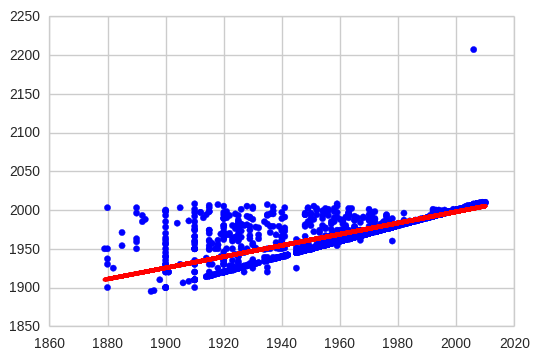

In [44]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
garage_year = built_year_data.loc[:,'GarageYrBlt'].values
built_year = built_year_data.loc[:,'YearBuilt'].values

length = garage_year.shape[0]
garage_year = garage_year.reshape(length, 1)
built_year = built_year.reshape(length, 1)

# Train the model using the training sets
regr.fit(built_year, garage_year)
plt.scatter(built_year, garage_year,  color='blue')
plt.plot(built_year, regr.predict(built_year), color='red',
         linewidth=3)

In [45]:
conbined_data['GarageYrBlt'] = conbined_data.apply(lambda row : int(regr.predict(row['YearBuilt']))
                                                      if row['GarageYrBlt'] == 'NA' else int(row['GarageYrBlt']),
                                                       axis=1)

In [46]:
conbined_data['GarageYrBlt'].head()

0    2003
1    1976
2    2001
3    1998
4    2000
Name: GarageYrBlt, dtype: int64

Using `YearBuilt` `YearRemodAdd` to check if has remoded or not.

In [47]:
# How many years has remoded from built
conbined_data['RemodYears'] = conbined_data['YearRemodAdd'] - conbined_data['YearBuilt']
# Did a remodeling happened from built?
conbined_data["HasRemodeled"] = (conbined_data["YearRemodAdd"] != conbined_data["YearBuilt"]) * 1
# Did a remodeling happen in the year the house was sold?
conbined_data["HasRecentRemodel"] = (conbined_data["YearRemodAdd"] == conbined_data["YrSold"]) * 1

In [48]:
conbined_data['GarageBltYears'] = conbined_data['GarageYrBlt'] - conbined_data['YearBuilt']

In [49]:
conbined_data['GarageBltYears'].head()

0     0
1     0
2     0
3    83
4     0
Name: GarageBltYears, dtype: int64

In [50]:
# How many years has build now?
conbined_data['Now_YearBuilt'] = 2017 - conbined_data['YearBuilt']
conbined_data['Now_YearRemodAdd'] = 2017 - conbined_data['YearRemodAdd']
conbined_data['Now_GarageYrBlt'] = 2017 - conbined_data['GarageYrBlt']

In [51]:
conbined_data[['Now_YearBuilt','Now_YearRemodAdd','Now_GarageYrBlt']].head(3)

,Now_YearBuilt,Now_YearRemodAdd,Now_GarageYrBlt
0,14,14,14
1,41,41,41
2,16,15,16


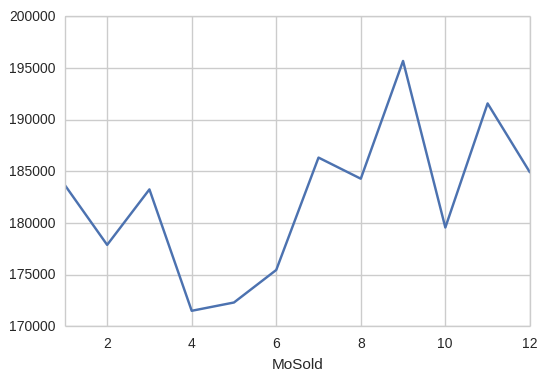

In [52]:
train_data['SalePrice'].groupby(train_data['MoSold']).mean().plot()

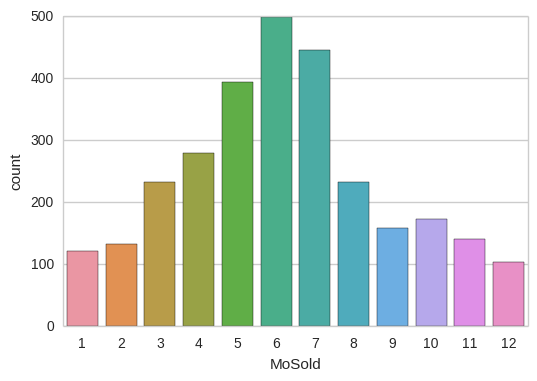

In [53]:
sns.countplot(conbined_data['MoSold'])

The number of houses sold per month is inversely proportional to the price.

In [54]:
sale_price_month = train_data['SalePrice'].groupby(train_data['MoSold']).mean().to_dict()
conbined_data["MonthSaledMeanPrice"] = conbined_data["MoSold"].replace(sale_price_month)

In [55]:
sale_month = {"1": 0, "2": 0, "3": 0, "4": 0, "5": 0, "6": 0, "7": 0, "8": 0, "9": 0, "10": 0, "11": 0, "12": 0}
for m in conbined_data['MoSold'].values:
    sale_month[str(m)] = sale_month[str(m)] + 1

In [56]:
conbined_data['MoSold'] = conbined_data['MoSold'].map(lambda m : str(m))

In [57]:
conbined_data["MonthSaledCount"] = conbined_data["MoSold"].replace(sale_month)

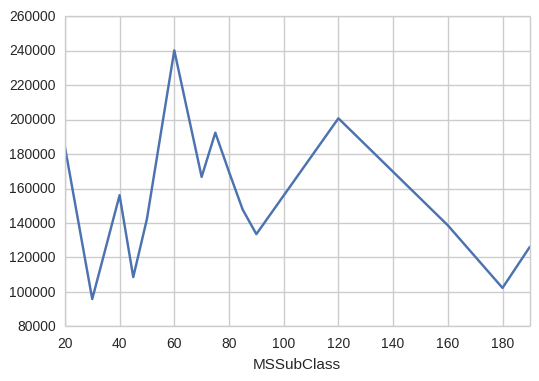

In [58]:
train_data['SalePrice'].groupby(train_data['MSSubClass']).mean().plot()

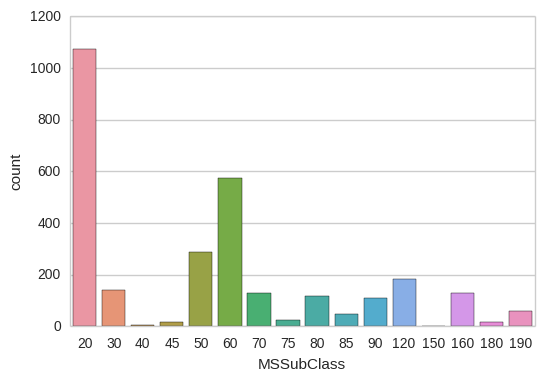

In [59]:
sns.countplot(conbined_data['MSSubClass'])

We can see that there is a certain relationship between price and sales volume and MSSubClass。That's because the house is NEWER or not！

In [60]:
conbined_data["NewerDwelling"] = conbined_data["MSSubClass"].replace(
    {20: 1, 30: 0, 40: 0, 45: 0,50: 0, 60: 1, 70: 0, 75: 0, 80: 0, 85: 0,
     90: 0, 120: 1, 150: 0, 160: 0, 180: 0, 190: 0})

In [61]:
sale_price_mssc = train_data['SalePrice'].groupby(train_data['MSSubClass']).mean().to_dict()
conbined_data["MSSubClassMeanPrice"] = conbined_data["MSSubClass"].replace(sale_price_mssc)

In [62]:
mssubclass_dict = {
    20: 'SC20',
    30: 'SC30',
    40: 'SC40',
    45: 'SC45',
    50: 'SC50',
    60: 'SC60',
    70: 'SC70',
    75: 'SC75',
    80: 'SC80',
    85: 'SC85',
    90: 'SC90',
    120: 'SC120',
    150: 'SC150',
    160: 'SC160',
    180: 'SC180',
    190: 'SC190',
}
conbined_data['MSSubClass'] = conbined_data['MSSubClass'].replace(mssubclass_dict)

Coding for attributes that have size properties.

In [63]:
good_level_map = {'Street': {'Grvl': 0, 'Pave': 1},
     'Alley': {'NA':0, 'Grvl': 1, 'Pave': 2},
     'Utilities': {'AllPub':3, 'NoSeWa': 1, 'NoSewr': 2, 'ELO': 0},
     'ExterQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1,'Po': 0},
     'ExterCond': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1,'Po': 0},
     'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1,'NA': 0},
     'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2,'Po': 1,'NA': 0},
     'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2,'Po': 1,'NA': 0},
     'BsmtFinType1': {'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
     'BsmtFinType2': {'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
     'HeatingQC': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1,'Po': 0},
     'CentralAir': {'N':0, 'Y':1},
     'KitchenQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0},
     'Functional': {'Typ':0,'Min1':1,'Min2':1,'Mod':2,'Maj1':3,'Maj2':4,'Sev':5,'Sal': 6},
     'FireplaceQu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
     'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
     'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
     'PoolQC': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'NA': 0},
     'Fence': {'GdPrv': 2, 'GdWo': 2, 'MnPrv': 1, 'MnWw': 1, 'NA': 0}
    }

print good_level_map.keys()
good_level_data = conbined_data[good_level_map.keys()].replace(good_level_map)

good_level_data.columns = good_level_data.columns.map(lambda m : m + '_')

conbined_data[good_level_data.columns] = good_level_data[good_level_data.columns]
print conbined_data.shape

['KitchenQual', 'BsmtCond', 'HeatingQC', 'GarageQual', 'ExterCond', 'CentralAir', 'ExterQual', 'Utilities', 'Alley', 'Functional', 'Street', 'FireplaceQu', 'Fence', 'BsmtFinType2', 'BsmtQual', 'PoolQC', 'BsmtExposure', 'BsmtFinType1', 'GarageCond']
(2911, 110)


The Neighborhood property indicates a nearby place name, which can be converted to latitude and longitude.

Ref: [Cleaning, new features (GPS coordinates included)](https://www.kaggle.com/juliensiems/house-prices-advanced-regression-techniques/cleaning-new-features-gps-coordinates-included/discussion)

In [64]:
# latitude
conbined_data["latitude"] = conbined_data.Neighborhood.replace(
                                               {'Blmngtn' : 42.062806,
                                                'Blueste' : 42.009408,
                                                'BrDale' : 42.052500,
                                                'BrkSide': 42.033590,
                                                'ClearCr': 42.025425,
                                                'CollgCr': 42.021051,
                                                'Crawfor': 42.025949,
                                                'Edwards': 42.022800,
                                                'Gilbert': 42.027885,
                                                'GrnHill': 42.000854,
                                                'IDOTRR' : 42.019208,
                                                'Landmrk': 42.044777,
                                                'MeadowV': 41.991866,
                                                'Mitchel': 42.031307,
                                                'NAmes'  : 42.042966,
                                                'NoRidge': 42.050307,
                                                'NPkVill': 42.050207,
                                                'NridgHt': 42.060356,
                                                'NWAmes' : 42.051321,
                                                'OldTown': 42.028863,
                                                'SWISU'  : 42.017578,
                                                'Sawyer' : 42.033611,
                                                'SawyerW': 42.035540,
                                                'Somerst': 42.052191,
                                                'StoneBr': 42.060752,
                                                'Timber' : 41.998132,
                                                'Veenker': 42.040106})
# longitude
conbined_data["longitude"] = conbined_data.Neighborhood.replace(
                                               {'Blmngtn' : -93.639963,
                                                'Blueste' : -93.645543,
                                                'BrDale' : -93.628821,
                                                'BrkSide': -93.627552,
                                                'ClearCr': -93.675741,
                                                'CollgCr': -93.685643,
                                                'Crawfor': -93.620215,
                                                'Edwards': -93.663040,
                                                'Gilbert': -93.615692,
                                                'GrnHill': -93.643377,
                                                'IDOTRR' : -93.623401,
                                                'Landmrk': -93.646239,
                                                'MeadowV': -93.602441,
                                                'Mitchel': -93.626967,
                                                'NAmes'  : -93.613556,
                                                'NoRidge': -93.656045,
                                                'NPkVill': -93.625827,
                                                'NridgHt': -93.657107,
                                                'NWAmes' : -93.633798,
                                                'OldTown': -93.615497,
                                                'SWISU'  : -93.651283,
                                                'Sawyer' : -93.669348,
                                                'SawyerW': -93.685131,
                                                'Somerst': -93.643479,
                                                'StoneBr': -93.628955,
                                                'Timber' : -93.648335,
                                                'Veenker': -93.657032})

# Ames city: longitude-93.63191310000002，latitude42.0307812，calcuate the distance
conbined_data["NeighborDistance"] = np.sqrt(np.power((conbined_data["longitude"] - (-93.63191310000002)),2) + \
                                    np.power((conbined_data["latitude"] - 42.0307812),2))

display(conbined_data["NeighborDistance"].head())

conbined_data.drop(['longitude', 'latitude'], axis=1, inplace=True)

0    0.054604
1    0.026794
2    0.054604
3    0.012657
4    0.031042
Name: NeighborDistance, dtype: float64

In [65]:
# Bin by neighborhood (a little arbitrarily). Values were computed by: 
neighbor_price_map = train_data["SalePrice"].groupby(train_data["Neighborhood"]).median().sort_values().to_dict()

In [66]:
neighbor_bin_map = {
    "MeadowV" : 0,  #  88000
    "IDOTRR" : 1,   # 103000
    "BrDale" : 1,   # 106000
    "OldTown" : 1,  # 119000
    "Edwards" : 1,  # 119500
    "BrkSide" : 1,  # 124300
    "Sawyer" : 1,   # 135000
    "Blueste" : 1,  # 137500
    "SWISU" : 2,    # 139500
    "NAmes" : 2,    # 140000
    "NPkVill" : 2,  # 146000
    "Mitchel" : 2,  # 153500
    "SawyerW" : 2,  # 179900
    "Gilbert" : 2,  # 181000
    "NWAmes" : 2,   # 182900
    "Blmngtn" : 2,  # 191000
    "CollgCr" : 2,  # 197200
    "ClearCr" : 3,  # 200250
    "Crawfor" : 3,  # 200624
    "Veenker" : 3,  # 218000
    "Somerst" : 3,  # 225500
    "Timber" : 3,   # 228475
    "StoneBr" : 4,  # 278000
    "NoRidge" : 4,  # 290000
    "NridgHt" : 4,  # 315000
}

conbined_data["NeighborPrice"] = conbined_data["Neighborhood"].map(neighbor_price_map)
conbined_data["NeighborBin"] = conbined_data["Neighborhood"].map(neighbor_bin_map)

In [67]:
conbined_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Fence_,BsmtFinType2_,BsmtQual_,PoolQC_,BsmtExposure_,BsmtFinType1_,GarageCond_,NeighborDistance,NeighborPrice,NeighborBin
0,1,SC60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,...,0,1,4,0,1,6,3,0.054604,197200,2
1,2,SC20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,...,0,1,4,0,4,5,3,0.026794,218000,3
2,3,SC60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,...,0,1,4,0,2,6,3,0.054604,197200,2
3,4,SC70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,...,0,1,3,0,1,5,3,0.012657,200624,3
4,5,SC60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,...,0,1,4,0,3,6,3,0.031042,301500,4


# Create new features

Ref: [juliencs : A study on Regression applied to the Ames dataset
](https://www.kaggle.com/juliencs/house-prices-advanced-regression-techniques/a-study-on-regression-applied-to-the-ames-dataset)
- Create some boolean features
- Discretize the continuous variables
- Simplifications of existing features - Ref
- Combinations of existing features - Ref,New
- Polynomials on the top 10 existing features - Ref

In [68]:
str_columns = conbined_data.select_dtypes(include=['object']).columns.values
num_columns = conbined_data.select_dtypes(exclude=['object']).columns.values

In [69]:
str_columns

array(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
       'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition'], dtype=object)

1.Create some boolean features

['Normal' 'Partial' 'Abnorml' 'Family' 'Alloca' 'AdjLand']


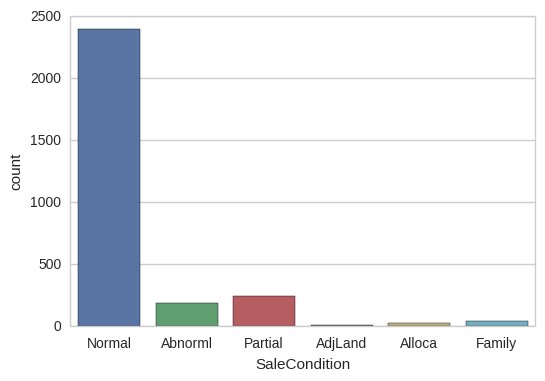

In [70]:
# test str column
column = "SaleCondition"
count_duct = {}
for key in set(conbined_data[column]):
    count_duct[key] = 0
    
for m in conbined_data[column].values:
    count_duct[str(m)] = count_duct[str(m)] + 1

count_duct= sorted(count_duct.items(), key=lambda d:d[1], reverse = True)
print np.array(count_duct)[:,0]
sns.countplot(conbined_data[column])

In [71]:
# IR2 and IR3 don't appear that often, so just make a distinction 
# between regular and irregular.
conbined_data["IsRegularLotShape"] = (conbined_data["LotShape"] == "Reg") * 1

# Bnk, Low, HLS don't appear that often, so just make a distinction
conbined_data["IsLandContourLvl"] = (conbined_data["LandContour"] == "Lvl") * 1
conbined_data["IsLotConfigInside"] = (conbined_data["LotConfig"] == "Inside") * 1
conbined_data["IsLandSlopeGentle"] = (conbined_data["LandSlope"] == "Gtl") * 1
conbined_data["IsCondition1Norm"] = (conbined_data["Condition1"] == "Norm") * 1
conbined_data["IsCondition2Norm"] = (conbined_data["Condition2"] == "Norm") * 1
conbined_data["IsBldgType1Fam"] = (conbined_data["BldgType"] == "1Fam") * 1
conbined_data["IsRoofStyleGable"] = (conbined_data["RoofStyle"] == "Gable") * 1
conbined_data["IsRoofMatlCompShg"] = (conbined_data["RoofMatl"] == "CompShg") * 1
conbined_data["IsGasAHeating"] = (conbined_data["Heating"] == "GasA") * 1
conbined_data["IsGarageFinished"] = (conbined_data["GarageFinish"] == "Fin") * 1
conbined_data["IsPavedDrive"] = (conbined_data["PavedDrive"] == "Y") * 1
conbined_data["IsSaleTypeWD"] = (conbined_data["SaleType"] == "WD") * 1
conbined_data["IsSaleConditionNormal"] = (conbined_data["SaleCondition"] == "Normal") * 1

In [72]:
# The only interesting "misc. feature" is the presence of a shed.
conbined_data["HasShed"] = (conbined_data["MiscFeature"] == "Shed") * 1.  

# Was this house sold in the year it was built?
conbined_data["IsVeryNewHouse"] = (conbined_data["YearBuilt"] == conbined_data["YrSold"]) * 1

conbined_data["Has2ndFloor"] = (conbined_data["2ndFlrSF"] == 0) * 1
conbined_data["Has2Story"] = (conbined_data["HouseStyle"] == '2Story') * 1
conbined_data["HasMasVnr"] = (conbined_data["MasVnrArea"] == 0) * 1
conbined_data["HasWoodDeck"] = (conbined_data["WoodDeckSF"] == 0) * 1
conbined_data["HasOpenPorch"] = (conbined_data["OpenPorchSF"] == 0) * 1
conbined_data["HasEnclosedPorch"] = (conbined_data["EnclosedPorch"] == 0) * 1
conbined_data["Has3SsnPorch"] = (conbined_data["3SsnPorch"] == 0) * 1
conbined_data["HasScreenPorch"] = (conbined_data["ScreenPorch"] == 0) * 1

2.Discretize the continuous variables

In [73]:
def house_new_level(year_built):
    if year_built < 1940:
        return 0
    elif year_built < 1970:
        return 1
    else:
        return 2

conbined_data['HouseNewLevel'] = conbined_data['YearBuilt'].map(house_new_level)

def mas_vnr_area_level(mas_vnr_area):
    if mas_vnr_area < 100:
        return 0
    elif mas_vnr_area < 300:
        return 1
    else:
        return 2

conbined_data['MasVnrAreaLevel'] = conbined_data['MasVnrArea'].map(mas_vnr_area_level)

def bsmt_fin_sf1_level(bsmt_fin_sf1):
    if bsmt_fin_sf1 < 100:
        return 0
    elif bsmt_fin_sf1 < 750:
        return 1
    else:
        return 2

conbined_data['BsmtFinSF1Level'] = conbined_data['BsmtFinSF1'].map(bsmt_fin_sf1_level)

def total_bsmt_sf_level(total_bsmt_sf):
    if total_bsmt_sf < 800:
        return 0
    elif total_bsmt_sf < 1300:
        return 1
    else:
        return 2

conbined_data['TotalBsmtSFLevel'] = conbined_data['TotalBsmtSF'].map(total_bsmt_sf_level)

def one_flr_sf_level(_1st_flr_sf):
    if _1st_flr_sf < 876.0:
        return 0
    elif _1st_flr_sf < 1383.0:
        return 1
    else:
        return 2

conbined_data['1stFlrSFLevel'] = conbined_data['1stFlrSF'].map(one_flr_sf_level)

def second_flr_sf_level(_2nd_flr_sf):
    if _2nd_flr_sf < 400.0:
        return 0
    elif _2nd_flr_sf < 900.0:
        return 1
    else:
        return 2

conbined_data['2ndFlrSFLevel'] = conbined_data['2ndFlrSF'].map(second_flr_sf_level)

def grliv_area_level(grliv_area):
    if grliv_area < 1125.0:
        return 0
    elif grliv_area < 1741.0:
        return 1
    else:
        return 2

conbined_data['GrLivAreaLevel'] = conbined_data['GrLivArea'].map(grliv_area_level)

def garage_area_level(garage_area):
    if garage_area < 320.0:
        return 0
    elif garage_area < 576.0:
        return 1
    else:
        return 2

conbined_data['GarageAreaLevel'] = conbined_data['GarageArea'].map(garage_area_level)

def open_porch_sf_area_level(open_porch_sf_area):
    if open_porch_sf_area < 20.0:
        return 0
    elif open_porch_sf_area < 100.0:
        return 1
    else:
        return 2

conbined_data['OpenPorchSFLevel'] = conbined_data['OpenPorchSF'].map(open_porch_sf_area_level)

def lotarea_level(lot_area):
    if lot_area < 7474.0:
        return 1
    elif lot_area < 11523.0:
        return 2
    else:
        return 3

conbined_data['LotAreaLevel'] = conbined_data['LotArea'].map(lotarea_level)

# train_data['SalePrice'].groupby(train_data['YrSold']).mean()
conbined_data['YearSoldMeanPrice'] = conbined_data['YrSold'].replace(
                                         {2006:182238, 2007:185266, 2008:177032, 2009:178851, 2010:177393})

7474.0
11523.0


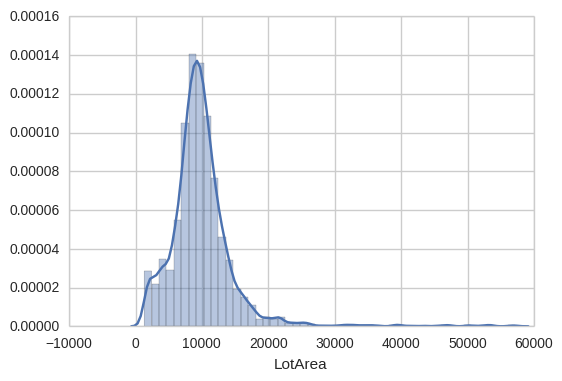

In [74]:
sns.distplot(conbined_data['LotArea'])
print conbined_data['LotArea'].quantile(0.25)
print conbined_data['LotArea'].quantile(0.75)

3.Simplifications of existing features

In [75]:
conbined_data["SimplOverallQual"] = conbined_data.OverallQual.replace(
                                                            {1 : 1, 2 : 1, 3 : 1, # bad
                                                             4 : 2, 5 : 2, 6 : 2, # average
                                                             7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                            })
conbined_data["SimplOverallCond"] = conbined_data.OverallCond.replace(
                                                            {1 : 1, 2 : 1, 3 : 1, # bad
                                                             4 : 2, 5 : 2, 6 : 2, # average
                                                             7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                             })
conbined_data["SimplPoolQC"] = conbined_data.PoolQC.replace(
                                                            {1 : 1, 2 : 1, 3 : 2, 4 : 2})
conbined_data["SimplGarageCond"] = conbined_data.GarageCond.replace(
                                                            {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
conbined_data["SimplGarageQual"] = conbined_data.GarageQual.replace(
                                                            {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
conbined_data["SimplFireplaceQu"] = conbined_data.FireplaceQu.replace(
                                                            {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
conbined_data["SimplFireplaceQu"] = conbined_data.FireplaceQu.replace(
                                                            {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
conbined_data["SimplFunctional"] = conbined_data.Functional.replace(
                                                            {1 : 1, 2 : 1, 3 : 2, 4 : 2, 5 : 3, 6 : 3, 7 : 3, 8 : 4})
conbined_data["SimplKitchenQual"] = conbined_data.KitchenQual.replace(
                                                            {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
conbined_data["SimplHeatingQC"] = conbined_data.HeatingQC.replace(
                                                            {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
conbined_data["SimplBsmtFinType1"] = conbined_data.BsmtFinType1.replace(
                                                            {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
conbined_data["SimplBsmtFinType2"] = conbined_data.BsmtFinType2.replace(
                                                            {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
conbined_data["SimplBsmtCond"] = conbined_data.BsmtCond.replace(
                                                            {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
conbined_data["SimplBsmtQual"] = conbined_data.BsmtQual.replace(
                                                            {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
conbined_data["SimplExterCond"] = conbined_data.ExterCond.replace(
                                                            {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
conbined_data["SimplExterQual"] = conbined_data.ExterQual.replace(
                                                            {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})

4.Combinations of existing features

In [76]:
# Using cross-validation to choose interactive features!
# Wait for testing
conbined_data.Basement = conbined_data.TotalBsmtSF * conbined_data.BsmtUnfSF
conbined_data.Ground   = conbined_data.GrLivArea * conbined_data.YearBuilt
conbined_data.Bath = conbined_data.FullBath * conbined_data.YearBuilt
conbined_data.AboveGround = conbined_data.TotRmsAbvGrd  * conbined_data.BedroomAbvGr 
conbined_data.livingArea = conbined_data.TotalBsmtSF  * conbined_data.GrLivArea  
conbined_data.years = conbined_data.YearBuilt  * conbined_data.YearRemodAdd 
conbined_data.Lot = conbined_data['1stFlrSF']  * conbined_data.LotFrontage 

In [77]:
# Overall quality of the house
conbined_data["OverallGrade"] = conbined_data["OverallQual"] * conbined_data["OverallCond"]
# Overall quality of the garage
conbined_data["GarageGrade"] = conbined_data["GarageQual_"] * conbined_data["GarageCond_"]
# Overall quality of the exterior
conbined_data["ExterGrade"] = conbined_data["ExterQual_"] * conbined_data["ExterCond_"]
# Overall kitchen score
conbined_data["KitchenScore"] = conbined_data["KitchenAbvGr"] * conbined_data["KitchenQual_"]
# Overall fireplace score
conbined_data["FireplaceScore"] = conbined_data["Fireplaces"] * conbined_data["FireplaceQu_"]
# Overall garage score
conbined_data["GarageScore"] = conbined_data["GarageArea"] * conbined_data["GarageQual_"]
# Overall pool score
conbined_data["PoolScore"] = conbined_data["PoolArea"] * conbined_data["PoolQC_"]

# Total number of bathrooms
conbined_data["TotalBath"] = conbined_data["BsmtFullBath"] + (0.5 * conbined_data["BsmtHalfBath"]) + \
conbined_data["FullBath"] + (0.5 * conbined_data["HalfBath"])

# Total yard area in square feet
conbined_data["TotalPorchSF"] = conbined_data["OpenPorchSF"] + conbined_data["EnclosedPorch"] +\
                                conbined_data["3SsnPorch"] + conbined_data["ScreenPorch"]
# Total SF for house (living, basement, porch, pool)
conbined_data["AllSF"] = conbined_data["GrLivArea"] + conbined_data["TotalBsmtSF"] + \
                         conbined_data["TotalPorchSF"] + conbined_data["WoodDeckSF"] + \
                         conbined_data["PoolArea"]

# House completed before sale or not
conbined_data["BoughtOffPlan"] = conbined_data.SaleCondition.replace(
    {"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})

In [78]:
# 4.Polynomials on the top n existing features
train_data_new = conbined_data.iloc[:train_length,:]
# 添加价格
train_data_new.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,GarageGrade,ExterGrade,KitchenScore,FireplaceScore,GarageScore,PoolScore,TotalBath,TotalPorchSF,AllSF,BoughtOffPlan
0,1,SC60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,...,9,6,3,0,1644.0,0,3.5,61,2627.0,0
1,2,SC20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,...,9,4,2,3,1380.0,0,2.5,0,2822.0,0
2,3,SC60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,...,9,6,3,3,1824.0,0,3.5,42,2748.0,0
3,4,SC70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,...,9,4,3,4,1926.0,0,2.0,307,2780.0,0
4,5,SC60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,...,9,6,3,3,2508.0,0,3.5,84,3619.0,0


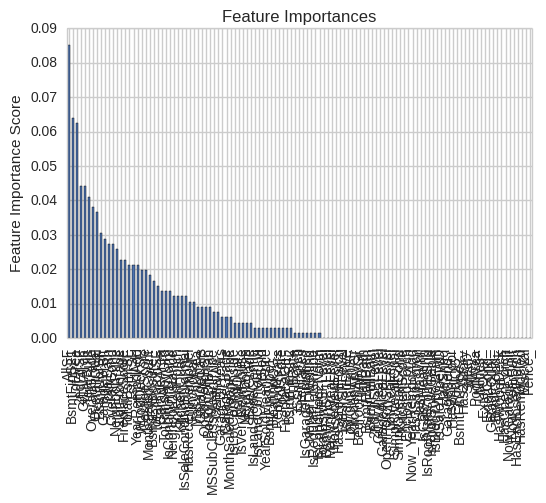

In [79]:
from xgboost import XGBRegressor

train_Y = train_data['SalePrice']
train_X = train_data_new.select_dtypes(exclude=['object']).drop(['Id'], axis=1)

xgb_regressor = XGBRegressor(seed=10)
xgb_regressor.fit(train_X, train_Y)

feature_importances = pd.Series(xgb_regressor.feature_importances_, train_X.columns.values)
feature_importances = feature_importances.sort_values(ascending=False)
# feature_importances= feature_importances.head(40)
feature_importances.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [80]:
top_n = 15
poly_columns = feature_importances.index.values[:top_n]
print poly_columns
for column in poly_columns:
    conbined_data[column+'-s2'] = conbined_data[column] ** 2
    conbined_data[column+'-s3'] = conbined_data[column] ** 3
    conbined_data[column+'-sq'] = np.sqrt(conbined_data[column])

['AllSF' 'BsmtFinSF1' 'LotArea' '2ndFlrSF' 'GrLivArea' 'YearBuilt'
 'OverallGrade' 'OverallQual' 'BsmtUnfSF' 'GarageYrBlt' 'TotalBath'
 'OverallCond' 'NeighborPrice' 'LotFrontage' 'FireplaceScore']


In [81]:
conbined_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,OverallCond-sq,NeighborPrice-s2,NeighborPrice-s3,NeighborPrice-sq,LotFrontage-s2,LotFrontage-s3,LotFrontage-sq,FireplaceScore-s2,FireplaceScore-s3,FireplaceScore-sq
0,1,SC60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,...,2.236068,38887840000,7668682048000000,444.072066,4225.0,274625.0,8.062258,0,0,0.000000
1,2,SC20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,...,2.828427,47524000000,10360232000000000,466.904701,6400.0,512000.0,8.944272,9,27,1.732051
2,3,SC60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,...,2.236068,38887840000,7668682048000000,444.072066,4624.0,314432.0,8.246211,9,27,1.732051
3,4,SC70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,...,2.236068,40249989376,8075113868570624,447.910705,3600.0,216000.0,7.745967,16,64,2.000000
4,5,SC60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,...,2.236068,90902250000,27407028375000000,549.090157,7056.0,592704.0,9.165151,9,27,1.732051


** Feature Scale / Skew **

Ref: [Lasso model for regression problem](https://www.kaggle.com/klyusba/house-prices-advanced-regression-techniques/lasso-model-for-regression-problem/notebook)

![](http://itknowledgeexchange.techtarget.com/writing-for-business/files/2012/12/skewness-300x247.png)

In [82]:
str_columns = conbined_data.select_dtypes(include=['object']).columns.values
num_columns = conbined_data.select_dtypes(exclude=['object']).columns.values[1:]

In [83]:
num_columns

array(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
       'PoolArea', 'MiscVal', 'YrSold', 'RemodYears', 'HasRemodeled',
       'HasRecentRemodel', 'GarageBltYears', 'Now_YearBuilt',
       'Now_YearRemodAdd', 'Now_GarageYrBlt', 'MonthSaledMeanPrice',
       'MonthSaledCount', 'NewerDwelling', 'MSSubClassMeanPrice',
       'KitchenQual_', 'BsmtCond_', 'HeatingQC_', 'GarageQual_',
       'ExterCond_', 'CentralAir_', 'ExterQual_', 'Utilities_', 'Alley_',
       'Functional_', 'Street_', 'FireplaceQu_', 'Fence_', 'BsmtFinType2_',
       'BsmtQual_', 'PoolQ

In [84]:
scater_skew_num_columns = num_columns.tolist()
print len(scater_skew_num_columns)
for column in num_columns:
    # for boolean features, do not scatter and skewed
    if set(conbined_data[column]) == {0, 1}:
        scater_skew_num_columns.remove(column)

print len(scater_skew_num_columns)

160
130


In [85]:
t = conbined_data[scater_skew_num_columns].quantile(.95)
use_max_scater = t[t == 0].index
use_95_scater = t[t != 0].index
conbined_data[use_max_scater] = conbined_data[use_max_scater] / conbined_data[use_max_scater].max()
conbined_data[use_95_scater] = conbined_data[use_95_scater] / conbined_data[use_95_scater].quantile(.95)

In [86]:
# Transform the skewed numeric features by taking log(feature + 1).
# This will make the features more normal.
from scipy.stats import skew

skewed = conbined_data[scater_skew_num_columns].apply(lambda x: skew(x.astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index.values
skewed_columns = []
for column in skewed:
    if (not column.endswith('_')) and ('Year' not in column) and ('Is' not in column) and ('Has' not in column) and ('Price' not in column):
        skewed_columns.append(column)
print skewed_columns
print 'skewed features', len(skewed_columns),' from total ',conbined_data.shape[1],' features'
conbined_data[skewed_columns] = np.log1p(conbined_data[skewed_columns])

['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MasVnrAreaLevel', '2ndFlrSFLevel', 'SimplOverallCond', 'ExterGrade', 'FireplaceScore', 'PoolScore', 'TotalPorchSF', 'AllSF', 'AllSF-s2', 'AllSF-s3', 'BsmtFinSF1-s2', 'BsmtFinSF1-s3', 'LotArea-s2', 'LotArea-s3', 'LotArea-sq', '2ndFlrSF-s2', '2ndFlrSF-s3', 'GrLivArea-s2', 'GrLivArea-s3', 'OverallGrade-s2', 'OverallGrade-s3', 'OverallQual-s2', 'OverallQual-s3', 'BsmtUnfSF-s2', 'BsmtUnfSF-s3', 'TotalBath-s2', 'TotalBath-s3', 'OverallCond-s2', 'OverallCond-s3', 'LotFrontage-s2', 'LotFrontage-s3', 'FireplaceScore-s2', 'FireplaceScore-s3']
skewed features 52  from total  219  features


In [87]:
conbined_data.shape

(2911, 219)

** Dummy Encoding **

In [88]:
str_columns

array(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
       'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition', 'SimplPoolQC',
       'SimplGarageCond', 'SimplGarageQual', 'SimplFireplaceQu',
       'SimplFunctional', 'SimplKitchenQual', 'SimplHeatingQC',
       'SimplBsmtFinType1', 'SimplBsmtFinType2', 'SimplBsmtCond',
       'SimplBsmtQual', 'SimplExterCond', 'SimplExterQual'], dtype=object)

In [89]:
dummies_data = pd.get_dummies(conbined_data[str_columns])
conbined_data[dummies_data.columns] = dummies_data[dummies_data.columns]
conbined_data.drop(str_columns, axis=1, inplace=True)

In [90]:
conbined_data.shape

(2911, 525)

Delete some features to prevent overfitting.

In [91]:
# These onehot columns are missing in the test data, so drop them from the
# training data or we might overfit on them.
drop_cols = [
                "Exterior1st_ImStucc", "Exterior1st_Stone",
                "Exterior2nd_Other","HouseStyle_2.5Fin", 
            
                "RoofMatl_Membran", "RoofMatl_Metal", "RoofMatl_Roll",
                "Condition2_RRAe", "Condition2_RRAn", "Condition2_RRNn",
                "Heating_Floor", "Heating_OthW",

                "Electrical_Mix", 
                "MiscFeature_TenC",
                "GarageQual_Ex", "PoolQC_Fa"
            ]

conbined_data.drop(drop_cols, axis=1, inplace=True)

In [92]:
conbined_data.shape

(2911, 509)

In [93]:
train_X = conbined_data.iloc[:train_length, 1:]
train_Y = train_data['SalePrice']
train_Id = conbined_data.iloc[:train_length, 0]

test_X = conbined_data.iloc[train_length:, 1:]
test_Id = conbined_data.iloc[train_length:, 0]

print("train_X : " + str(train_X.shape))
print("test_X : " + str(test_X.shape))
print("train_Y : " + str(train_Y.shape))

train_X : (1452, 508)
test_X : (1459, 508)
train_Y : (1452,)


(array([   5.,   12.,   54.,  184.,  469.,  400.,  215.,   88.,   19.,    6.]),
 array([ 10.46027076,  10.76769112,  11.07511148,  11.38253184,
         11.6899522 ,  11.99737256,  12.30479292,  12.61221328,
         12.91963363,  13.22705399,  13.53447435]),
 <a list of 10 Patch objects>)

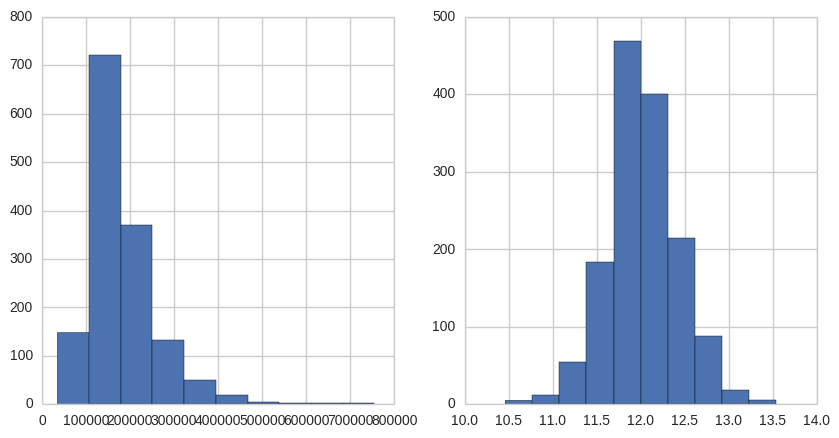

In [94]:
# SalePrice distribution
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,5))
axis1.hist(train_Y)
# Transform skewed numeric features using log(p+1) transformation making them more normal
train_Y = np.log1p(train_Y)
axis2.hist(train_Y)

# Save New Data

In [95]:
save_train = train_X.copy()
save_test = test_X.copy()
save_train['Id'] = train_Id
save_train['SalePrice'] = train_Y
save_test['Id'] = test_Id

display(save_train.head())
display(save_test.head())

save_train.to_csv("data/new_train.csv", index=False)
save_test.to_csv("data/new_test.csv", index=False)

print 'Done.'

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SimplExterCond_Fa,SimplExterCond_Gd,SimplExterCond_Po,SimplExterCond_TA,SimplExterQual_Ex,SimplExterQual_Fa,SimplExterQual_Gd,SimplExterQual_TA,Id,SalePrice
0,0.625000,0.405761,0.875,0.625,0.998007,0.998007,0.353963,0.440935,0.0,0.096725,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,12.247699
1,0.769231,0.450153,0.750,1.000,0.984554,0.984554,0.000000,0.569657,0.0,0.175869,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2,12.109016
2,0.653846,0.510589,0.875,0.625,0.997010,0.997509,0.300867,0.323152,0.0,0.257614,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3,12.317171
3,0.576923,0.448263,0.875,0.625,0.954160,0.981565,0.000000,0.156615,0.0,0.311598,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4,11.849405
4,0.807692,0.612228,1.000,0.625,0.996512,0.996512,0.564402,0.414840,0.0,0.286497,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,5,12.429220


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SimplExterCond_Ex,SimplExterCond_Fa,SimplExterCond_Gd,SimplExterCond_Po,SimplExterCond_TA,SimplExterQual_Ex,SimplExterQual_Fa,SimplExterQual_Gd,SimplExterQual_TA,Id
0,0.769231,0.523724,0.625,0.750,0.977080,0.977080,0.000000,0.312872,0.286817,0.167887,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1461
1,0.778846,0.612453,0.750,0.750,0.975585,0.975585,0.210277,0.544931,0.000000,0.242853,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1462
2,0.711538,0.598325,0.625,0.625,0.995017,0.995516,0.000000,0.482969,0.000000,0.088703,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1463
3,0.750000,0.464324,0.750,0.750,0.995516,0.995516,0.042424,0.386980,0.000000,0.198329,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1464
4,0.413462,0.259604,1.000,0.625,0.992526,0.992526,0.000000,0.187671,0.000000,0.523875,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1465


Done.
